In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.constants import *
import sys
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib
import math
import sympy as sp
import scipy.sparse as sparse
import time
from numpy.linalg import LinAlgError

from scipy.optimize import curve_fit
from scipy import signal
from mpl_toolkits.mplot3d import Axes3D
from colour import Color

from sklearn.decomposition import PCA as sklearnPCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import auc
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami

The following cell contains all the known parameters.

In [2]:
#KmDhaTH = 0.77 #Km for H in N + H <--> D + P
#KmDhaTN = 0.03 #Km for N in N + H <--> D + P
#KiDhaTD = 0.23 #Ki for D in N + H <--> D + P
#KiDhaTP = 7.4  #Ki for P in N + H <--> D + P

KmDhaTH = 1.0 #Km for H in N + H <--> D + P
KmDhaTN = 1.0 #Km for N in N + H <--> D + P
KiDhaTD = 1.0 #Ki for D in N + H <--> D + P
KiDhaTP = 1.0  #Ki for P in N + H <--> D + P
VfDhaT = 86.2  #V_f for N + H <--> D + P

T = 298 # room temperature in kelvin
R =  8.314 # gas constant
DeltaGDhaT = -35.1/(R*T) # using Ph 7.8 since the IcdE reaction is forward processing
DeltaGDhaB = -18.0/(R*T) # using Ph 7.8 since the IcdE reaction is forward processing
DeltaGIcdE = -11.4/(R*T) # using Ph 7.8 since the IcdE reaction is forward processing

# cell and MCP constants
perm_cell = 0.01
perm_mcp = 1.0 
Vratio = 10
Rc = 1.e-5 #Radius of compartment (cm)
Diff = 1.e-4 #Diffusion coefficient
Rb = 5.e-5 #Effective Radius of cell (cm)
D = Diff/(Rc**2)
r_mcp = 1. # why? 
r_cell = Rb/Rc # why?

# mcp parameters
n_compounds_mcp = 7
n_compounds_cell = 5


ngrid = int(25)

The following cell contains all the unknown constants set to 1.0 and the initial conditions for $N$ and $D$ set to 100.

In [3]:
# DhaB reaction constants
VfDhaB = 60.0
KmDhaBG = 1.0
KiDhaBH = 1.0

# IcdE reaction constants
VfIcdE = 100.0
KmIcdED = 1.0
KmIcdEI = 1.0
KiIcdEA = 1.0
KiIcdEN = 1.0

# initial conditions for GInit
GInit = 100.0

# initial conditions for NInit
NInit = 400.0

# initial condition for DInit
DInit = 400.0

# initial condition for AInit
IInit = 500.0


I set the non-dimensional parameters below.

In [4]:
# state space and time scaling
G0 = KmDhaBG
H0 = KmDhaTH
N0 = KmDhaTN
P0 = KiDhaTP
D0 = KmIcdED
A0 = KiIcdEA
I0 = KmIcdEI
t0 = 3*r_mcp/perm_mcp

y0 = np.zeros((ngrid+2)*n_compounds_cell+2)
y0[-5] = GInit/G0 #y0[-5] gives the initial state of the external substrate. The /G0 turns the value into a dimensionless quantity
y0[-1] = IInit/I0 #y0[-1] gives the initial state of the external substrate. The /A0 turns the value into a dimensionless quantity
y0[0] = NInit/N0 #y0[5] gives the initial state of the external substrate. The /N0 turns the value into a dimensionless quantity
y0[1] = DInit/D0 #y0[6] gives the initial state of the external substrate. The /D0 turns the value into a dimensionless quantity

param_list = np.zeros((22))
#non-dimensional parameters
param_list[0] = t0*VfDhaB/G0
param_list[1] = t0*VfDhaB/H0
param_list[2] = t0*VfDhaT/H0
param_list[3] = t0*VfDhaT/N0
param_list[4] = t0*VfIcdE/N0
param_list[5] = t0*VfDhaT/P0
param_list[6] = t0*VfDhaT/D0
param_list[7] = t0*VfIcdE/D0
param_list[8] = t0*VfIcdE/I0
param_list[9] = t0*VfIcdE/A0

param_list[10] = KmDhaTH/KiDhaBH
param_list[11] = KmIcdED/KiDhaTD
param_list[12] = KmDhaTN/KiIcdEN


param_list[13] = (H0/KmDhaBG)*np.exp(DeltaGDhaB)
param_list[14] = (P0*D0/(KmDhaTH*KmDhaTN))*np.exp(DeltaGDhaT)
param_list[15] = (A0*N0/(KmIcdED*KmIcdEI))*np.exp(DeltaGIcdE)

param_list[16] = perm_mcp
param_list[17] = perm_cell

param_list[18] = GInit
param_list[19] = NInit
param_list[20] = DInit
param_list[21] = IInit


Below computes the spatial derivative.

In [5]:
def SDeriv(t,x,params): #spatial derivative

    alpha_list = params[:10]
    beta_list = params[10:13]
    gamma_list = params[13:16]
    perm_mcp = params[16]
    perm_cell = params[17]
    
    ### why this scaling ####
    M_cell = (Rb/Rc)**3/3. # why?
    M_mcp = 1./3. # why?
    M = M_mcp
    DeltaM = np.divide((M_cell-M_mcp),(ngrid))

    ### why this scaling ####

    assert len(x) == 5*(2+(ngrid)) + 2 

    d = np.zeros((len(x))).tolist() # convert to list to allow use of symbolic derivatives


    ###################################################################################
    ################################## MCP reactions ##################################
    ###################################################################################

    R_DhaB = (x[2] - gamma_list[0]*x[3])/(1+x[2]+x[3]*beta_list[0])
    R_DhaT = (x[3]*x[0] - gamma_list[1]*x[4]*x[1])/(1+x[3]*x[0]+beta_list[1]*x[4]*x[1])
    R_IcdE = (x[1]*x[6]- gamma_list[2]*x[5]*x[0])/(1+x[6]*x[1]+beta_list[2]*x[5]*x[0])

    d[0] = -alpha_list[3]*R_DhaT + alpha_list[4]*R_IcdE                                #microcompartment equation for N
    d[1] = alpha_list[6]*R_DhaT - alpha_list[7]*R_IcdE                                 #microcompartment equation for D
    
    d[2] = -alpha_list[0]*R_DhaB + x[2+n_compounds_cell] - x[2]                 #microcompartment equation for G
    d[3] = alpha_list[1]*R_DhaB - alpha_list[2]*R_DhaT + x[3+n_compounds_cell] - x[3]  #microcompartment equation for H
    d[4] = alpha_list[5]*R_DhaT + x[4+n_compounds_cell] - x[4]                  #microcompartment equation for P
    d[5] =   alpha_list[8]*R_IcdE + x[5+n_compounds_cell] - x[5]               #microcompartment equation for A
    d[6] = - alpha_list[9]*R_IcdE + x[6+n_compounds_cell] - x[6]                  #microcompartment equation for I

    
    ####################################################################################
    ##################################### boundary of MCP ##############################
    ####################################################################################

    M = M_mcp
    for i in range(7,12):        
        first_coef =  t0*(3**(4./3.))*(D/(DeltaM)**2)*((((M + 0.5*DeltaM)**4.)**(1./3.)) 
                                                    + (((M - 0.5*DeltaM)**4.)**(1./3.)))
        second_coef = t0*(perm_mcp*(((M - 0.5*DeltaM)**4.)**(1./3.))*3**(2./3.))/(DeltaM*M_mcp**(2/3))

        # BC at MCP for the ith compound in the cell 
        d[i] = first_coef*(x[i+n_compounds_cell]-x[i]) - second_coef*(x[i] - x[i-n_compounds_cell]) 


    ####################################################################################
    ##################################### interior of cell #############################
    ####################################################################################

    for k in range(2,(ngrid+1)): 
        start_ind = 7 + (k-1)*n_compounds_cell
        end_ind =  7 + k*n_compounds_cell
        M += DeltaM # updated M
        #cell equations for ith compound in the cell 
        for i in range(start_ind,end_ind):
            coef = t0*((3**(4./3.))*D/(DeltaM)**2)
            d[i] = coef*((((M + 0.5*DeltaM)**4.)**(1./3.))*(x[i+n_compounds_cell]-x[i]) 
                         - (((M - 0.5*DeltaM)**4.)**(1./3.))*(x[i]-x[i-n_compounds_cell]))

    ####################################################################################
    ###################### boundary of cell with external volume #######################
    ####################################################################################

    M = M_cell
    
    first_coef = t0*(3**(4./3.))*(D/(DeltaM)**2)*((((M + 0.5*DeltaM)**4)**(1/3.)) 
                                                  + (((M - 0.5*DeltaM)**4)**(1/3.)))
    second_coef = t0*(perm_cell*(((M + 0.5*DeltaM)**4)**(1/3.))*3**(2./3.))/(DeltaM*M_cell**(2/3))
       


    for i in reversed(range(-6,-11,-1)):
        # BC at ext volume for the ith compound in the cell 
        d[i] = first_coef*(x[i-n_compounds_cell] - x[i]) - second_coef*(x[i] - x[i+n_compounds_cell])
        

    #####################################################################################
    ######################### external volume equations #################################
    #####################################################################################
    
    for i in reversed(range(-1,-6,-1)):
        d[i] = t0*(3*perm_cell/r_cell)*(x[i - n_compounds_cell] - x[i])/(Vratio) #external equation for concentration
    
    return d

In [6]:
SDerivParameterized = lambda t,x: SDeriv(t,x,param_list)

x_list_sp = np.array(sp.symbols('x:' + str( 5*(2+(ngrid)) + 2)))
SDerivSymbolic = SDeriv(0,x_list_sp,param_list)
SDerivGrad = sp.Matrix(SDerivSymbolic).jacobian(x_list_sp)
SDerivGradFun = sp.lambdify(x_list_sp, SDerivGrad, 'numpy')
SDerivGradFunSparse = lambda t,x: sparse.csr_matrix(SDerivGradFun(*x))

In [9]:
SDerivParameterized(0,y0)

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 46.566853874444334,
 0.0,
 0.0,
 0.0,
 232.83426937222166,
 -0.18000000000000002,
 0.0,
 0.0,
 0.0,
 -0.9000000000000001]

In [296]:
# time samples
fintime = 1e4
tol = 1e-11
nsamples = int(1e3)
timeorig = np.linspace(0,fintime,nsamples)

# terminal event
event = lambda t,y: np.absolute(SDerivParameterized(t,y)[-1]) - tol
event.terminal = True


sol = solve_ivp(SDerivParameterized,[0, fintime], y0, method="BDF",jac=SDerivGradFunSparse, events = event,
                t_eval=timeorig, atol=1.0e-12,rtol=1.0e-12)

In [297]:
sol.message

'The solver successfully reached the end of the integration interval.'

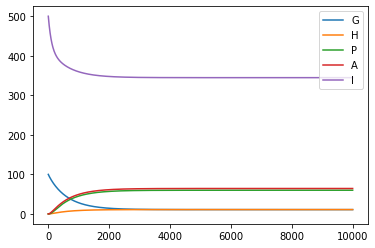

In [298]:
%matplotlib inline
plt.plot(sol.t,sol.y[-5:,:].T)
plt.legend(['G','H','P','A','I'],loc='upper right')
#filename = "VfDhaB_"+str(VfDhaB)+"_KmDhaBG_" + str(KmDhaBG) + "_KiDhaBH_" + str(KiDhaBH) + "_VfIcdE_"  + str(VfIcdE) + "_KmIcdEA_" + str(KmIcdEA) + "_KmIcdEN_" + str(KmIcdEN) + "_KiIcdED_" + str(KiIcdED) + "_KiIcdEI_" + str(KiIcdEI) + "_GInit_" + str(GInit) + "_NInit_" + "_GInit_" + str(GInit) + "_NInit_" + str(NInit) + "_DInit_" + str(DInit) + "_AInit_" + str(AInit)
#plt.savefig('/Users/aarcher/PycharmProjects/MCP/WholeCell/plots/ScipyCode_' + filename + '.png')
plt.show()

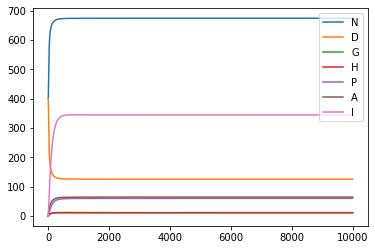

In [301]:
%matplotlib inline
plt.plot(sol.t,sol.y[:7,:].T)
plt.legend(['N','D','G','H','P','A','I'],loc='upper right')
#filename = "VfDhaB_"+str(VfDhaB)+"_KmDhaBG_" + str(KmDhaBG) + "_KiDhaBH_" + str(KiDhaBH) + "_VfIcdE_"  + str(VfIcdE) + "_KmIcdEA_" + str(KmIcdEA) + "_KmIcdEN_" + str(KmIcdEN) + "_KiIcdED_" + str(KiIcdED) + "_KiIcdEI_" + str(KiIcdEI) + "_GInit_" + str(GInit) + "_NInit_" + "_GInit_" + str(GInit) + "_NInit_" + str(NInit) + "_DInit_" + str(DInit) + "_AInit_" + str(AInit)
#plt.savefig('/Users/aarcher/PycharmProjects/MCP/WholeCell/plots/ScipyCode_' + filename + '.png')
plt.show()

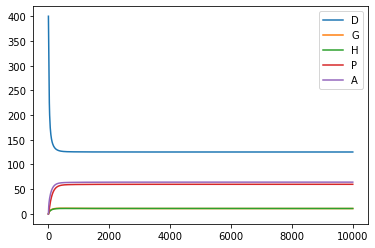

In [302]:
%matplotlib inline
plt.plot(sol.t,sol.y[1:6,:].T)
plt.legend(['D','G','H','P','A'],loc='upper right')
#filename = "VfDhaB_"+str(VfDhaB)+"_KmDhaBG_" + str(KmDhaBG) + "_KiDhaBH_" + str(KiDhaBH) + "_VfIcdE_"  + str(VfIcdE) + "_KmIcdEA_" + str(KmIcdEA) + "_KmIcdEN_" + str(KmIcdEN) + "_KiIcdED_" + str(KiIcdED) + "_KiIcdEI_" + str(KiIcdEI) + "_GInit_" + str(GInit) + "_NInit_" + "_GInit_" + str(GInit) + "_NInit_" + str(NInit) + "_DInit_" + str(DInit) + "_AInit_" + str(AInit)
#plt.savefig('/Users/aarcher/PycharmProjects/MCP/WholeCell/plots/ScipyCode_' + filename + '.png')
plt.show()

### Compute concentration statistics:
- compute area under the curve of P

In [267]:
auc(sol.t,sol.y[-3,:].T)

554667.1831240703

- steady state flux of $P_{\text{cell}}$ at the cell boundary

In [268]:
# flux of all compounds
4*math.pi*(r_cell**2)*(sol.y[-6:-1,-1] - sol.y[(-6-n_compounds_cell):(-1-n_compounds_cell),-1])

array([ 3.57157734e-11,  2.27274874e-03, -1.22955878e-04, -2.14979287e-03,
       -2.15051306e-03])

In [269]:
4*math.pi*(r_cell**2)*(sol.y[-3,-1] - sol.y[-3-n_compounds_cell,-1])

-0.0021497928711628643

- steady state flux of $P_{\text{mcp}}$ at MCP

In [270]:
# flux of all compounds
4*math.pi*(r_cell**2)*perm_mcp*(sol.y[2:7,-1] - sol.y[7:(7+n_compounds_cell),-1])

array([-2.14558397e-04,  1.13827911e-05,  2.03175606e-04,  2.03243720e-04,
       -2.03243716e-04])

In [271]:
4*math.pi*(r_cell**2)*perm_mcp*(sol.y[4,-1] - sol.y[4+n_compounds_cell,-1])

0.00020317560593665786

- steady state concentration of $P_{\text{ext}}$

In [272]:
sol.y[-3,-1]

59.92487297092216

## Stiff Solver

In [ ]:
import sympy as sp
import scipy.sparse as sparse
import time
from numpy.linalg import LinAlgError

In [ ]:
def newton(f, x0, fprime, full_output=True, conv_tol =1e-5, root_tol = 1e-5, max_iters=5,output_level=0):
    # initialize parameters
    converged = False
    xn = x0
    iters = 0 
    status = -99
    
    

    #initialize function
    fn = f(xn)
    norm_f = np.max(np.absolute(fn))
    diff_x = np.max(np.absolute(xn - x0))
    gradn = fprime(xn)
    
    #print statement
    if output_level >= 2:
        output_header = '%6s %9s %9s' % ('iter', '||f||_1', '||x_n-x_0||_1')
        print(output_header)
        print('%6i %9.2e %9.2e' % (iters, norm_f, diff_x))
        
    while 1:
        ###########################################
        ########### Convergence Checks ############
        ###########################################
        if iters > 0 and diff_x < root_tol:
            status = 1
            converged = True
            break

        if norm_f < conv_tol:
            status = 0
            converged = True
            break

        if iters >= max_iters:
            status = -1
            break
            
        ###########################################
        ############## Newton step ################
        ###########################################
        
        try:
            delta = sparse.linalg.spsolve(gradn,fn)
            xn = xn - delta
            iters += 1
        except LinAlgError:
            status = -2
            break
            
        #update difference in x
        diff_x = np.max(np.absolute(xn - x0))
        #update function
        fn = f(xn)
        norm_f = np.max(np.absolute(fn))
        
        # print statement
        if output_level >= 2 and iters % 100 == 0:
            output_header = '%6s %9s %9s' % ('iter', '||f||_1', '||x_n-x_0||_1')
            print(output_header)
            
        if output_level >= 2 and iters % 10 ==0:
            print('%6i %9.2e %9.2e' % (iters, norm_f, diff_x))
    
    if output_level >= 1:
        print('')
        print('||f||_1 at final point...............: %g' % norm_f)
        print('||x_n-x_0||_1 at final point.........: %g' % diff_x)
        print('Number of iterations.................: %d' % iters)
        print('')

        if status == 1:
            print('Exit: Critical point found since ||x_n-x0||_1 is less than tolerance.')
        elif status == 0:
            print('Exit: Critical point found since ||f(x_n)||_1 is less than tolerance.')
        elif status == -1:
            print('Exit: Maximum number of iterations (%d) exceeded.' %
                  iters)
        elif status == -2:
            print('Exit: Singular jacobian matrix.')
        else:
            print('ERROR: Unknown status value: %d\n' % status)

    if full_output==True:
        return [converged, xn]
    else:
        return xn

In [ ]:
class BDF:
    def __init__(self,rhs, y0, tspan, devrhs = None, order = 2, dt = 1e-2, max_dt = 1.0, min_dt = 1e-7, dt_cut = 2, 
                 dt_raise=2, abstol=1e-6,reltol=1e-6, devtol = 1e-5, maxtime = 5.*60.):
        '''
        Initialization of multistep BDF scheme object
        Args:
            rhs: right hand side of the differential equation
            y0 : initial conditions 
            tspan: time interval of integration. A list of two vectors.
            devrhs: derivative of the rhs wrt to state vectors
            dt: initial time step
            max_dt: maximum time step
            min_dt: minimum time step
            dt_cut: factor to reduce time step. If non-adaptive set, dt_cut = 1.0
            dt_raise: factor to increase time step. If non-adaptive set, dt_raise = 1.0
            abstol: absolute error tolerance
            reltol: relative error tolerance
            devtol: tolerance of the derivative to be 0
            maxtime: maximum time to run the program
        '''
        self.rhs = rhs
        self.y0 = y0
        self.t0 = tspan[0]
        self.devrhs = devrhs
        self.order = order
        self.tspan = tspan
        self.dt = dt
        self.max_dt = max_dt
        self.min_dt = min_dt
        self.dt_cut = dt_cut
        self.dt_raise = dt_raise
        self.abstol = abstol
        self.reltol = reltol
        self.devtol = devtol
        self.maxtime = maxtime
        
        
    def step(self,t,*argv):
        '''
        Multistep backwards differentiation
        
        Args: 
            t: current time of the time interval
            argv[0]: current state vector, y_n
            argv[1]: previous state vector, y_n-1
            argv[2]: 2nd previous state vector, y_n-2
        '''
        yvals = {}
        for i,arg in enumerate(argv): 
            if i == 0:
                yvals["y_"+str(i)] = arg
            else:
                yvals["y_-"+str(i)] = arg

        if len(argv) == 1:
            #BDF-1 
            numeric_scheme = lambda y_next: y_next - yvals["y_0"] - self.dt*self.rhs(t,y_next)
            df = lambda y_next: sparse.identity(len(yvals["y_0"])) - self.dt*self.devrhs(t,y_next)
            iter_sol = newton(numeric_scheme, yvals["y_0"], fprime = df, full_output=True)
        elif len(argv) == 2:
            #BDF-2
            numeric_scheme = lambda y_next: y_next - (4./3.)*yvals["y_0"] + (1./3.)*yvals["y_-1"] - self.dt*(2./3.)*self.rhs(t,y_next)
            df = lambda y_next: sparse.identity(len(yvals["y_0"])) - self.dt*(2./3.)*self.devrhs(t,y_next)
            iter_sol = newton(numeric_scheme, yvals["y_0"], fprime = df, full_output=True)
        elif len(argv) == 3:
            #BDF-3
            numeric_scheme = lambda y_next: y_next - (18./11.)*yvals["y_0"] + (9./11.)*yvals["y_-1"] - (2./11.)*yvals["y_-2"] - self.dt*(6./11.)*self.rhs(t,y_next)
            df = lambda y_next: sparse.identity(len(yvals["y_0"])) - self.dt*(6./11.)*self.devrhs(t,y_next)
            iter_sol = newton(numeric_scheme, yvals["y_0"], fprime = df, full_output=True)
        elif len(argv) == 4:
            #BDF-4 -- this is unstable
            numeric_scheme = lambda y_next: y_next - 4.*(12./25.)*yvals["y_0"] + 3.*(12./25.)*yvals["y_-1"] - (4./3.)*(12./25.)*yvals["y_-2"] + (1./4.)*(12./25.)*yvals["y_-3"] - self.dt*(12./25.)*self.rhs(t,y_next)
            df = lambda y_next: sparse.identity(len(yvals["y_0"])) - self.dt*(12./25.)*self.devrhs(t,y_next)
            iter_sol = newton(numeric_scheme, yvals["y_0"], fprime = df, full_output=True)
        elif len(argv) == 5:
            #BDF-5 -- this is unstable
            numeric_scheme = lambda y_next: y_next - 5.*(60./137.)*yvals["y_0"] + 5.*(60./137.)*yvals["y_-1"] - (10./3.)*(60./137.)*yvals["y_-2"] + (5./4.)*(60./137.)*yvals["y_-3"] - (1./5.)*(60./137.)*yvals["y_-4"] - self.dt*(60./137.)*self.rhs(t,y_next)
            df = lambda y_next: sparse.identity(len(yvals["y_0"])) - self.dt*(60./137.)*self.devrhs(t,y_next)
            iter_sol = newton(numeric_scheme, yvals["y_0"], fprime = df, full_output=True)

        return [iter_sol[0], iter_sol[1]]
    
    
    def initialize(self,h=1e-12):
        '''
        Generate order-1 entries for a multistep BDF scheme using RK4
        Args:
            order: order of the BDF scheme
            h: stepsize for RK4. Note -- take h small so as to not affect the 
               order and error of the BDF scheme to be ran
        
        '''
        order = self.order 
        while(len(self.t) < order):
            y = self.y[-1]
            t = self.t[-1]
            
            # take a step Rk4 step 
            
            k1 = self.rhs(t,y)
            k2 = self.rhs(t + h/2., y + k1*h/2.)
            k3 = self.rhs(t + h/2., y + k2*h/2.)
            k4 = self.rhs(t + h, y + k3*h)
            
            ynew = y + (k1 + 2.*k2 + 2.*k3 + k4)*h/6.
            tnew = t + h
            
            # store step
            
            (self.y).append(ynew)
            (self.t).append(tnew)
            
            
            
    def integrate(self,initalize_h =1e-100):
        
        self.y = [self.y0]
        self.t = [self.t0]
        
        # parameters for integration
        order = self.order
        dt = self.dt
        min_dt = self.min_dt
        max_dt = self.max_dt
        dt_cut = self.dt_cut
        dt_raise = self.dt_raise
        tspan = self.tspan
        devtol = self.devtol
        maxtime = self.maxtime
        reltol = self.reltol
        abstol = self.abstol
        
        status = -99
        
        output_header = '{}' .format('    t     \t     dt     \t ||slope||_1 \t time')
        print(output_header)
        print('%3.4e \t %3.4e  \t %3.4e \t %9.4e' % (self.t[-1], self.dt, 0.0, 0.0))
        # initialize with RK45
        if order > 1:
            self.initialize(initalize_h)
            
        ##################################
        ########### Begin Loop ###########
        ##################################
        
        # start time
        start_time = time.time()
        
        
        while 1:

            # compute time of loop
            current_time = time.time()
            total_time = current_time - start_time
            maxgrad = np.max(np.absolute(self.rhs(self.t[-1],self.y[-1])))
            # reset dt
            if dt > max_dt:
                dt = max_dt
                self.dt = dt
            
            # potential new time
            tnew = self.t[-1] + dt
            
            if tnew > tspan[-1]:
                dt = tspan[-1] - self.t[-1]
                self.dt = dt
                tnew = self.t[-1] + dt
            #########################################
            ############ Break Conditions ###########
            #########################################
            
            
            if not (self.t[-1] < tspan[-1]):
                # end of interval
                status = 0
                break
                
            if dt < min_dt:
                #step size too small
                status = -1
                break
                
            if maxgrad < devtol:
                # 1-norm of derivative too small
                status = -2
                break 
            
            if total_time > maxtime:
                # time of the program exceeded
                status = -3
                break
            
            ##########################################
            ############## Take Time Step ############
            ##########################################
            

            # take a step
            yns = self.y[-order:] # get the last "order" vectors
            yns = yns[::-1] # reverse the order of the vectors
            iter_converged,ynew = self.step(self.t[-1],*yns)
            
            if len(self.t) % 100 == 0:
                print(output_header)
            
            if len(self.t) % 10 == 0:
                print('%3.4e \t %3.4e  \t %3.4e \t %9.4e' % (self.t[-1], self.dt, maxgrad, total_time))
                
            ###########################################
            ###### Error and Convergence Checks #######
            ###########################################
            
            abs_error = np.absolute(ynew  - self.y[-1])
            

            # check convergence, error
            #if (not iter_converged) | np.any(ynew < 0) | np.any(abs_error > abstol):
            #    dt/= dt_cut
            #    self.dt = dt
            #else:
            #    dt *= dt_raise
            #    self.dt = dt
            #    (self.t).append(tnew)
            #    (self.y).append(ynew)
            (self.t).append(tnew)  
            (self.y).append(ynew)
            ###########################################
            ############ Print Statements #############
            ###########################################
            

            
        ##################################
        ############ End Loop ############
        ##################################

        ##################################
        ######## Finalize results ########
        ##################################
        
        print(output_header)
        print('%3.4e \t %3.4e  \t %3.4e \t %9.4e' % (self.t[-1], self.dt, maxgrad, total_time))

        print('')
        print('Status ..................................................: %d' % status)
        print('Final time...............................................: %g' % self.t[-1])
        print('Time of loop.............................................: %g' % total_time)
        print('Maximum slope............................................: %g' % maxgrad)
        print('')

        if status == 0:
            print('Exit: Intergration Success.')
        elif status == -1:
            print('Exit: Step size, ' + '{:.2E}'.format(dt) + ', is smaller than smallest allowed step-size.')
        elif status == -2:
            print('Exit: Steady state reached.')
        elif status == -3:
            print('Exit: Integration is taking too long, %3.4e seconds.' % total_time)
        else:
            print('ERROR: Unknown status value: %d\n' % status)
        return [status,np.array(self.t),np.array(self.y)]
    
    

In [ ]:
x_list_sp = np.array(sp.symbols('x:' + str( 5*(2+(ngrid)) + 2)))
SDerivSymbolic = SDeriv(0,x_list_sp,param_list)
SDerivGrad = sp.Matrix(SDerivSymbolic).jacobian(x_list_sp)
SDerivGradFun = sp.lambdify(x_list_sp, SDerivGrad, 'numpy')
SDerivGradFunSparse = lambda t,x: sparse.csr_matrix(SDerivGradFun(*x))
SDerivParameterized = lambda t,x: np.array(SDeriv(t,x,param_list))

In [ ]:
bdf=BDF(SDerivParameterized, y0, [0,1e7], devrhs = SDerivGradFunSparse, dt = 1, min_dt=1e-30, max_dt = 1e8,abstol=10.,order=3,maxtime = 5.*60.)
[status,t,y] = bdf.integrate()
status

In [ ]:
%matplotlib inline
plt.plot(bdf.t,np.array(bdf.y)[:,-5:])
plt.legend(['G','H','P','A','I'],loc='upper right')
#filename = "VfDhaB_"+str(VfDhaB)+"_KmDhaBG_" + str(KmDhaBG) + "_KiDhaBH_" + str(KiDhaBH) + "_VfIcdE_"  + str(VfIcdE) + "_KmIcdEA_" + str(KmIcdEA) + "_KmIcdEN_" + str(KmIcdEN) + "_KiIcdED_" + str(KiIcdED) + "_KiIcdEI_" + str(KiIcdEI) + "_GInit_" + str(GInit) + "_NInit_" + "_GInit_" + str(GInit) + "_NInit_" + str(NInit) + "_DInit_" + str(DInit) + "_AInit_" + str(AInit)
plt.savefig('/Users/aarcher/PycharmProjects/MCP/WholeCell/plots/AndreCode_ExternalDynamics.png')
plt.show()

In [ ]:
%matplotlib inline
plt.plot(bdf.t,np.array(bdf.y)[:,:7])
plt.legend(['N','D','G','H','P','A','I'],loc='upper right')
filename = "VfDhaB_"+str(VfDhaB)+"_KmDhaBG_" + str(KmDhaBG) + "_KiDhaBH_" + str(KiDhaBH) + "_VfIcdE_"  + str(VfIcdE) + "_KmIcdEA_" + str(KmIcdEA) + "_KmIcdEN_" + str(KmIcdEN) + "_KiIcdED_" + str(KiIcdED) + "_KiIcdEI_" + str(KiIcdEI) + "_GInit_" + str(GInit) + "_NInit_" + "_GInit_" + str(GInit) + "_NInit_" + str(NInit) + "_DInit_" + str(DInit) + "_AInit_" + str(AInit)
plt.savefig('/Users/aarcher/PycharmProjects/MCP/WholeCell/plots/AndreCode_MCPDynamics.png')
plt.show()

In [ ]:
plt.plot(bdf.t,np.array(bdf.y)[:,-3])
plt.legend(['D','G','H','P','A','I'],loc='upper right')
#plt.savefig('/Users/aarcher/PycharmProjects/MCP/WholeCell/plots/AndreCode_MCPDynamicsWithoutN.png')
plt.show()

## Local Sensitivity Analysis with Sensitivity Equations

In [343]:
# parameter symbols
params_sp = list(sp.symbols('alpha0:10'))
params_sp.extend(sp.symbols('beta0:3'))
params_sp.extend(sp.symbols('gamma:3'))

params_sp.append(sp.symbols('km'))
params_sp.append(sp.symbols('kc'))
# initial conditions symbols
params_sp.append(sp.symbols('GInit'))
params_sp.append(sp.symbols('NInit'))
params_sp.append(sp.symbols('DInit'))
params_sp.append(sp.symbols('IInit'))

# x variables
x_list_sp = np.array(sp.symbols('x:' + str( 5*(2+(ngrid)) + 2)))

nVars = len(x_list_sp)
nParams = len(params_sp)
nSensitivityEqs = nVars*nParams

#senstivity variables
sensitivityVars = np.array(list(sp.symbols('s0:' + str(nSensitivityEqs))))


# Jacobian
SDerivSymbolic = sp.Matrix(SDeriv(0,x_list_sp,params_sp))
SDerivSymbolicJacParams = SDerivSymbolic.jacobian(params_sp) 

SDerivSymbolicJacConc = SDerivSymbolic.jacobian(x_list_sp) 

# senstivity equations
ds = []
for i in range(len(x_list_sp)):
    for j in range(len(params_sp)):
        ds.extend(np.dot(SDerivSymbolicJacConc[i,:],sensitivityVars[range(j,nSensitivityEqs,nParams)]) 
                  + SDerivSymbolicJacParams[i,j])


In [373]:
# define sensitvity equations as a function
dx = SDeriv(0,x_list_sp,params_sp)
dxs = np.concatenate([dx,ds])
dxs  = sp.Matrix(dxs)


#function of parameters
dxsFuncParams = sp.lambdify(params_sp, dxs)
dxsVars = dxsFuncParams(*param_list)

# function of state variables
allvars = np.concatenate([x_copy,sensitivityVars])
dxsVarsFunc =  sp.lambdify(allvars, dxsVars)
dxsVarsFunctx = lambda t,xs: dxsVarsFunc(*xs)

In [363]:
# initial conditions
xs0 = np.concatenate([y0, np.zeros(nSensitivityEqs)])
xs0[len(y0)] = 1
xs0[len(y0)+1] = 1
xs0[-5] = 1
xs0[-1] = 1

In [ ]:
dxsVarsMat = sp.Matrix(dxsVars)
allvars = np.concatenate([x_copy,sensitivityVars])
#xsVars  = sp.Matrix(np.concatenate([x_copy,sensitivityVars]))
dxsVarsMatJac = dxsVarsMat.jacobian(allvars)
dxsVarsMatJacFunc = sp.lambdify(allvars,dxsVarsMatJac)
dxsVarsMatJacFunctx = lambda t,xs: sparse.csr_matrix(dxsVarsMatJacFunc(*xs))

In [ ]:
# time samples
fintime = 1e4
tol = 1e-11
nsamples = int(1e2)
timeorig = np.linspace(0,fintime,nsamples)

# terminal event
event = lambda t,xs: np.absolute(dxsVarsFunctx(t,xs)[len(x)-1]) - tol
event.terminal = True


sol = solve_ivp(dxsVarsFunctx,[0, fintime], xs0, method="BDF", events = event,
                t_eval=timeorig, atol=1.0e-12,rtol=1.0e-12)

## Graphical Local Sensitivity Analysis

In [ ]:
def model_IcdE(KmDhaBG,KiDhaBH,VfDhaB,KmIcdEN,KmIcdEA,KiIcdED,KiIcdEI,VfIcdE,NInit,DInit):
    # state space and time scaling
    G0 = KmDhaBG
    H0 = KmDhaTH
    N0 = KmDhaTN
    P0 = KiDhaTP
    D0 = KiIcdED
    A0 = KmIcdEA
    I0 = KiIcdEI
    t0 = 3*r_mcp/perm_mcp

    y0[-5] = SInit/G0 #y0[-5] gives the initial state of the external substrate. The /G0 turns the value into a dimensionless quantity
    y0[5] = NInit/N0 #y0[-5] gives the initial state of the external substrate. The /G0 turns the value into a dimensionless quantity
    y0[6] = DInit/D0 #y0[-5] gives the initial state of the external substrate. The /G0 turns the value into a dimensionless quantity

    #non-dimensional parameters
    alpha1 = t0*VfDhaB*(1-np.exp(DeltaGDhaB))/G0
    alpha2 = t0*VfDhaB*(1-np.exp(DeltaGDhaB))/H0
    alpha3 = t0*VfDhaT*(1-np.exp(DeltaGDhaT))/H0
    alpha4 = t0*VfDhaT*(1-np.exp(DeltaGDhaT))/N0
    alpha5 = t0*VfIcdE*KmDhaTN*(1-np.exp(DeltaGIcdE))/(N0*KmIcdEN)
    alpha6 = t0*VfDhaT*(1-np.exp(DeltaGDhaT))/P0
    alpha7 = t0*VfDhaT*(1-np.exp(DeltaGDhaT))/D0
    alpha8 = t0*VfIcdE*KmDhaTN*(1-np.exp(DeltaGIcdE))/(D0*KmIcdEN)
    alpha9 = t0*VfIcdE*KmDhaTN*(1-np.exp(DeltaGIcdE))/(I0*KmIcdEN)
    alpha10 = t0*VfIcdE*KmDhaTN*(1-np.exp(DeltaGIcdE))/(A0*KmIcdEN)

    beta1 = KmDhaTH/KiDhaBH
    beta2 = KiIcdED/KiDhaTD
    beta3 = KmDhaTN/KmIcdEN

    SDev = rhs(KmDhaBG,KiDhaBH,VfDhaB,KmIcdEN,KmIcdEA,KiIcdED,KiIcdEI,VfIcdE)

    sol = odeint(SDev, y0, timeorig)
    
    return sol[-1,-5]


In [ ]:
problem = {
    'num_vars': 10,
    'names': ['KmDhaBG','KiDhaBH','VfDhaB','KmIcdEN','KmIcdEA','KiIcdED','KiIcdEI','VfIcdE','NInit','DInit'],
    'bounds': np.repeat([[5,10]], 10,axis=0)
}



In [ ]:
param_values = saltelli.sample(problem, 2)

In [ ]:
param_values.shape[0]

In [ ]:
Y = np.zeros([param_values.shape[0]])

for i, X in enumerate(param_values):
    Y[i] = model_IcdE(*X)

In [ ]:
sobol.analyze(problem, Y)

In [ ]:
# manual local senstivity analysis

test_vals = [1.0,10.0]

for KmDhaBG in test_vals: #Km for G in G <--> H
    for KiDhaBH in test_vals: #Km for H in G <--> H
        for VfDhaB in test_vals: #Vf for G <--> H
            for KmIcdEN in test_vals: #Km for N in N + A <--> I + D
                for KmIcdEA in test_vals: #Km for A in N + A <--> I + D
                    for KiIcdED in test_vals: #Ki for D in N + A <--> I + D
                        for KiIcdEI in test_vals: #Ki for I in N + A <--> I + D
                            for VfIcdE in test_vals: #Vf for N + A <--> I + D


                                # state space and time scaling
                                G0 = KmDhaBG
                                H0 = KmDhaTH
                                N0 = KmDhaTN
                                P0 = KiDhaTP
                                D0 = KiIcdED
                                A0 = KmIcdEA
                                I0 = KiIcdEI
                                t0 = 3*r_mcp/perm_mcp

                                y0[-5] = SInit/G0 #y0[-5] gives the initial state of the external substrate. The /G0 turns the value into a dimensionless quantity
                                y0[5] = NInit/N0 #y0[-5] gives the initial state of the external substrate. The /G0 turns the value into a dimensionless quantity
                                y0[6] = DInit/D0 #y0[-5] gives the initial state of the external substrate. The /G0 turns the value into a dimensionless quantity

                                #non-dimensional parameters
                                alpha1 = t0*VfDhaB*(1-np.exp(DeltaGDhaB))/G0
                                alpha2 = t0*VfDhaB*(1-np.exp(DeltaGDhaB))/H0
                                alpha3 = t0*VfDhaT*(1-np.exp(DeltaGDhaT))/H0
                                alpha4 = t0*VfDhaT*(1-np.exp(DeltaGDhaT))/N0
                                alpha5 = t0*VfIcdE*KmDhaTN*(1-np.exp(DeltaGIcdE))/(N0*KmIcdEN)
                                alpha6 = t0*VfDhaT*(1-np.exp(DeltaGDhaT))/P0
                                alpha7 = t0*VfDhaT*(1-np.exp(DeltaGDhaT))/D0
                                alpha8 = t0*VfIcdE*KmDhaTN*(1-np.exp(DeltaGIcdE))/(D0*KmIcdEN)
                                alpha9 = t0*VfIcdE*KmDhaTN*(1-np.exp(DeltaGIcdE))/(I0*KmIcdEN)
                                alpha10 = t0*VfIcdE*KmDhaTN*(1-np.exp(DeltaGIcdE))/(A0*KmIcdEN)

                                beta1 = KmDhaTH/KiDhaBH
                                beta2 = KiIcdED/KiDhaTD
                                beta3 = KmDhaTN/KmIcdEN
                                
                                #spatial derivative
                                SDev = rhs(KmDhaBG,KiDhaBH,VfDhaB,KmIcdEN,KmIcdEA,KiIcdED,KiIcdEI,VfIcdE)
                                
                                #solution
                                sol = odeint(SDev, y0, timeorig)
                                
                                #plot solution
                                plt.plot(timeorig,sol[:,-5:])
                                plt.show()
